Descripción:

En este problema, se proporciona un conjunto de datos que contiene imágenes de escenas naturales de todo el mundo. El objetivo es construir un modelo de clasificación utilizando redes neuronales convolucionales (CNN) para clasificar estas imágenes en una de las seis categorías predefinidas.

Dataset:

El dataset proporcionado contiene alrededor de 25,000 imágenes de tamaño 150x150, distribuidas en seis categorías:

-buildings

-forest

-glacier

-mountain

-sea

-street

Las imágenes están divididas en tres conjuntos:

Train: Alrededor de 14,000 imágenes para entrenamiento.

Test: Alrededor de 3,000 imágenes para evaluación del modelo.

Prediction: Alrededor de 7,000 imágenes para predicción final.

Objetivo:

Utilizando el dataset proporcionado, el objetivo es construir y comparar el rendimiento de distintos modelos de clasificación de imágenes utilizando redes neuronales convolucionales y densas que puedan clasificar con precisión las imágenes de escenas naturales en una de las seis categorías mencionadas
anteriormente.

Los modelos a diseñar son:

Modelo con capas densas.

Modelo con capas convolucionales y densas.

Modelo que incluya bloques residuales identidad:

Modelo que utilice como backbone alguna de las arquitecturas disponibles en TensorFlow (transfer learning): https://www.tensorflow.org/api_docs/python/tf/keras/applications

Se debe entrenar y evaluar cada modelo utilizando técnicas adecuadas de validación y métricas de evaluación de clasificación.

Entrega:

La entrega debe incluir:

Código fuente de la solución implementada en Google Colab, que incluya:
Análisis previo y preprocesamiento del set de datos.
Definición y entrenamiento del modelo.
Resultados de la evaluación del modelo, incluyendo métricas de desempeño y visualizaciones relevantes.
Nota: el código debe estar debidamente documentado con comentarios explicativos para que el trabajo sea fácilmente comprensible para otros revisores.


In [ ]:
!pip install -q gdown

In [ ]:
import gdown
import zipfile
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from pathlib import Path
from keras.layers import Input, RandomFlip, RandomContrast, BatchNormalization, RandomTranslation, Flatten, Dropout
from keras.layers import Dense, Conv2D, Activation, MaxPooling2D, GlobalMaxPooling2D, Rescaling
from PIL import Image
from tensorflow.keras.models import Sequential

In [ ]:
# TP1-3-natural-scenes.zip
gdown.download('https://drive.google.com/uc?id=1Pqs5Y6dZr4R66Dby5hIUIjPZtBI28rmJ')

Downloading...
From (original): https://drive.google.com/uc?id=1Pqs5Y6dZr4R66Dby5hIUIjPZtBI28rmJ
From (redirected): https://drive.google.com/uc?id=1Pqs5Y6dZr4R66Dby5hIUIjPZtBI28rmJ&confirm=t&uuid=208c5a23-92b8-4245-95be-8821208e24d4
To: /content/TP1-3-natural-scenes.zip
100%|██████████| 363M/363M [00:09<00:00, 37.7MB/s]


'TP1-3-natural-scenes.zip'

In [ ]:
with zipfile.ZipFile('TP1-3-natural-scenes.zip', 'r') as zip_ref:
    zip_ref.extractall('./TP1-3')

In [ ]:
# Configurar para que TensorFlow utilice la GPU por defecto
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Configurar para que TensorFlow asigne memoria dinámicamente
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        # Especificar la GPU por defecto
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Manejar error
        print(e)

In [ ]:
"""
# Directorio de los datos
TRAIN_DATA_DIRECTORY = Path("TP1-3/seg_train/seg_train")
VALIDATION_DATA_DIRECTORY = Path("TP1-3/seg_test/seg_test")

# Tamaño del lote (batch size)
BATCH_SIZE = 64
# Tamaño de las imágenes
IMAGE_HEIGHT = 64
IMAGE_WIDTH = 64

# Carga los datos de entrenamiento y validación
train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DATA_DIRECTORY,
    label_mode="categorical",
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE)

val_ds = tf.keras.utils.image_dataset_from_directory(
    VALIDATION_DATA_DIRECTORY,
    label_mode="categorical",
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE)
"""

Found 14034 files belonging to 6 classes.
Found 3000 files belonging to 6 classes.


In [ ]:
# Directorio de los datos
DATA_DIRECTORY = Path("TP1-3/seg_train/seg_train")
# Tamaño del lote (batch size)
BATCH_SIZE = 64
# Tamaño de las imágenes
IMAGE_HEIGHT = 64
IMAGE_WIDTH = 64

# Carga los datos de entrenamiento y validación
train_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIRECTORY,
    validation_split=0.2,
    subset="training",
    label_mode="categorical",
    seed=123,
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE)

val_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIRECTORY,
    validation_split=0.2,
    subset="validation",
    label_mode="categorical",
    seed=123,
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE)

Found 14034 files belonging to 6 classes.
Using 11228 files for training.
Found 14034 files belonging to 6 classes.
Using 2806 files for validation.


In [ ]:
# Obtiene los nombres de las clases
class_names = train_ds.class_names
num_classes = len(class_names)
print(class_names)

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


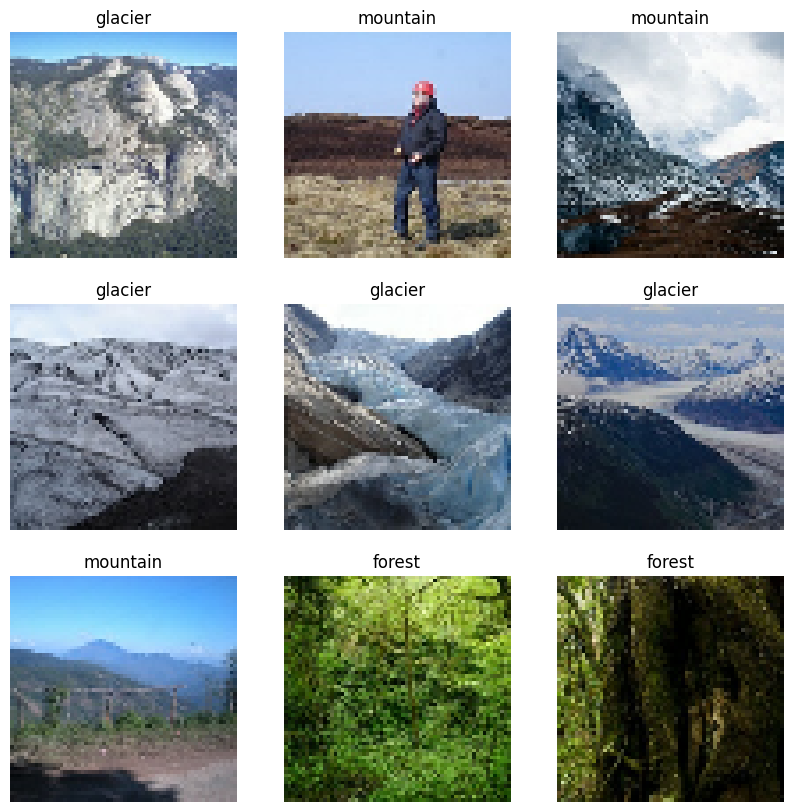

In [ ]:
# Muestra algunas imágenes de ejemplo
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    class_idx = list(labels[i]).index(1)
    plt.title(class_names[class_idx])
    plt.axis("off")

In [ ]:
# Muestra algunas imágenes de ejemplo
plt.figure(figsize=(10, 10))
for images, labels in val_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    class_idx = list(labels[i]).index(1)
    plt.title(class_names[class_idx])
    plt.axis("off")

#Modelos con Capas Densas

In [ ]:
def build_model_dense(input_shape, output_labels):
    # Definir la entrada
    i = Input(input_shape, dtype=tf.float32)

    # Preprocesamiento de imágenes
    x = Rescaling(1./255)(i)

    # Capas de aumentación de datos
    x = RandomFlip("horizontal")(x)
    x = RandomFlip("vertical")(x)
    x = RandomTranslation(0.1, 0.1, fill_mode="reflect")(x)
    x = RandomContrast(0.2)(x)

    # Aplanar la entrada
    x = Flatten()(x)

    # Capas densas
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.3)(x)

    x = Dense(32, activation='relu')(x)
    x = Dropout(0.3)(x)

    # Capa de salida
    x = Dense(output_labels, activation='softmax')(x)

    # Definir el modelo
    model = tf.keras.Model(inputs=i, outputs=x)
    return model

In [ ]:
print("Building model")
model_dense = build_model_dense((IMAGE_HEIGHT, IMAGE_WIDTH, 3), num_classes)

model_dense.compile(
    optimizer='adam',
    loss="categorical_crossentropy",
    metrics=['accuracy'])

Building model


In [ ]:
model_dense.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 64, 64, 3)         0         
                                                                 
 random_flip_2 (RandomFlip)  (None, 64, 64, 3)         0         
                                                                 
 random_flip_3 (RandomFlip)  (None, 64, 64, 3)         0         
                                                                 
 random_translation_1 (Rand  (None, 64, 64, 3)         0         
 omTranslation)                                                  
                                                                 
 random_contrast_1 (RandomC  (None, 64, 64, 3)         0         
 ontrast)                                                  

In [ ]:
# Número de épocas de entrenamiento
EPOCHS = 10
# Entrena el modelo
history_dense = model_dense.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE
)

Epoch 1/10
176/176 [==============================] - 16s 84ms/step - loss: 1.8627 - accuracy: 0.1706 - val_loss: 1.7914 - val_accuracy: 0.1693
Epoch 2/10
176/176 [==============================] - 14s 80ms/step - loss: 1.7910 - accuracy: 0.1734 - val_loss: 1.7913 - val_accuracy: 0.1782
Epoch 3/10
176/176 [==============================] - 12s 68ms/step - loss: 1.7908 - accuracy: 0.1792 - val_loss: 1.7913 - val_accuracy: 0.1782
Epoch 4/10
176/176 [==============================] - 14s 81ms/step - loss: 1.7907 - accuracy: 0.1792 - val_loss: 1.7913 - val_accuracy: 0.1782
Epoch 5/10
176/176 [==============================] - 16s 91ms/step - loss: 1.7908 - accuracy: 0.1792 - val_loss: 1.7913 - val_accuracy: 0.1782
Epoch 6/10
176/176 [==============================] - 13s 71ms/step - loss: 1.7907 - accuracy: 0.1792 - val_loss: 1.7913 - val_accuracy: 0.1782
Epoch 7/10
176/176 [==============================] - 14s 78ms/step - loss: 1.7908 - accuracy: 0.1792 - val_loss: 1.7913 - val_accuracy:

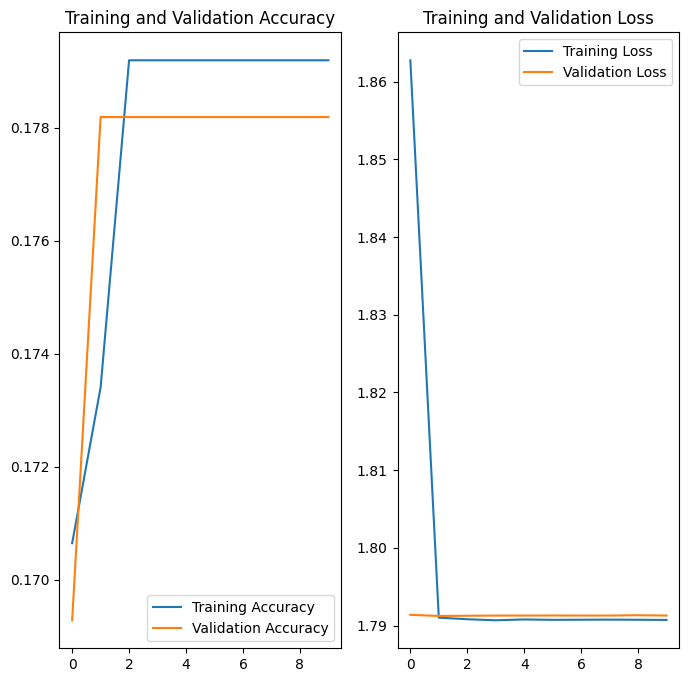

In [ ]:
# Grafica la precisión y pérdida de entrenamiento y validación
acc = history_dense.history['accuracy']
val_acc = history_dense.history['val_accuracy']

loss = history_dense.history['loss']
val_loss = history_dense.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#Modelo con capas Convolucionales y Densas

In [ ]:
# Función para construir el modelo
def build_model(input_shape, output_labels):
    i = Input(input_shape, dtype=tf.float32)

    x = Rescaling(1./255)(i)
    x = RandomFlip("horizontal")(x)
    x = RandomFlip("vertical")(x)
    x = RandomTranslation(0.1, 0.1, fill_mode="reflect")(x)
    x = RandomContrast(0.2)(x)

    x = Conv2D(8, (3, 3))(x)
    x = Activation("relu")(x)

    x = Conv2D(16, (3, 3))(x)
    x = Activation("relu")(x)

    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(32, (3, 3))(x)
    x = Activation("relu")(x)

    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(64, (3, 3))(x)
    x = Activation("relu")(x)

    x = MaxPooling2D((2, 2))(x)

    x = Flatten()(x)
    x = Dropout(0.3)(x)
    x = Dense(output_labels)(x)
    x = Activation("softmax")(x)
    return tf.keras.Model(inputs=[i], outputs=[x])

In [ ]:
print("Building model")
model = build_model((IMAGE_HEIGHT, IMAGE_WIDTH, 3), num_classes)

model.compile(
    optimizer='adam',
    loss="categorical_crossentropy",
    metrics=['accuracy'])

Building model


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 rescaling (Rescaling)       (None, 64, 64, 3)         0         
                                                                 
 random_flip (RandomFlip)    (None, 64, 64, 3)         0         
                                                                 
 random_flip_1 (RandomFlip)  (None, 64, 64, 3)         0         
                                                                 
 random_translation (Random  (None, 64, 64, 3)         0         
 Translation)                                                    
                                                                 
 random_contrast (RandomCon  (None, 64, 64, 3)         0         
 trast)                                                      

In [ ]:
# Número de épocas de entrenamiento
EPOCHS = 10
# Entrena el modelo
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE
)

Epoch 1/10
176/176 [==============================] - 66s 360ms/step - loss: 1.3645 - accuracy: 0.4402 - val_loss: 1.2901 - val_accuracy: 0.4733
Epoch 2/10
176/176 [==============================] - 60s 340ms/step - loss: 1.0741 - accuracy: 0.5686 - val_loss: 0.9503 - val_accuracy: 0.6376
Epoch 3/10
176/176 [==============================] - 61s 344ms/step - loss: 1.0184 - accuracy: 0.5999 - val_loss: 0.9744 - val_accuracy: 0.6294
Epoch 4/10
176/176 [==============================] - 60s 340ms/step - loss: 0.9726 - accuracy: 0.6249 - val_loss: 0.8682 - val_accuracy: 0.6675
Epoch 5/10
176/176 [==============================] - 59s 332ms/step - loss: 0.9275 - accuracy: 0.6496 - val_loss: 0.8020 - val_accuracy: 0.7046
Epoch 6/10
176/176 [==============================] - 59s 332ms/step - loss: 0.8716 - accuracy: 0.6729 - val_loss: 0.8230 - val_accuracy: 0.6939
Epoch 7/10
176/176 [==============================] - 61s 344ms/step - loss: 0.8517 - accuracy: 0.6820 - val_loss: 0.7466 - val_ac

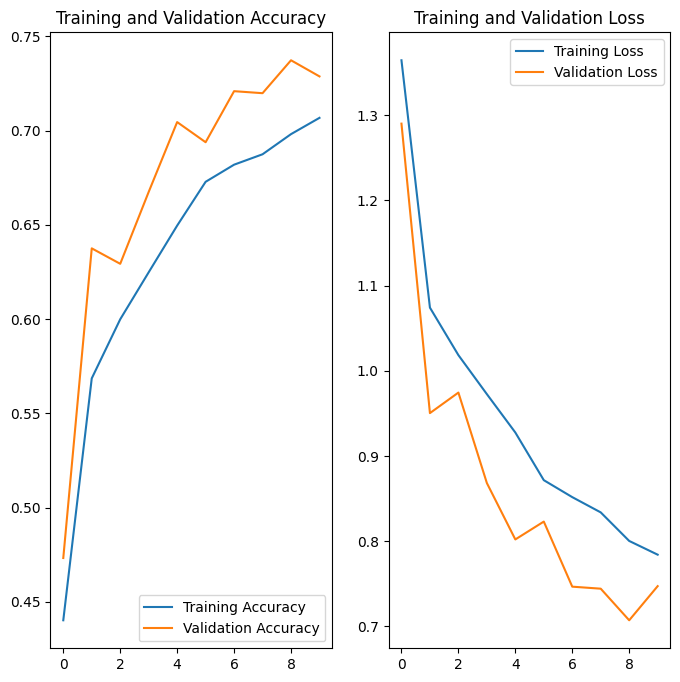

In [ ]:
# Grafica la precisión y pérdida de entrenamiento y validación
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#Modelo con Bloques Residuales Identidad

In [ ]:
def model_residual(input_shape, output_labels):
    inputs = Input(shape=input_shape)

    x = Rescaling(1./255)(inputs)
    x = RandomFlip("horizontal")(x)
    x = RandomFlip("vertical")(x)
    x = RandomTranslation(0.1, 0.1, fill_mode="reflect")(x)
    x = RandomContrast(0.2)(x)


#Modelo con Transfer Learning


In [ ]:
def build_model_tl(input_shape, num_classes):
    base_model = tf.keras.applications.EfficientNetB0(input_shape=input_shape,
                                                include_top=False,
                                                weights='imagenet')
    base_model.trainable = False

    i = Input(shape=input_shape)
    x = base_model(i, training=False)
    x = GlobalMaxPooling2D()(x)
    x = Dense(num_classes, activation='softmax')(x)

    return tf.keras.Model(i, x)

In [ ]:
print("Building model")
model_tl = build_model_tl((IMAGE_HEIGHT, IMAGE_WIDTH, 3), num_classes)

model_tl.compile(
    optimizer='adam',
    loss="categorical_crossentropy",
    metrics=['accuracy'])

Building model
16705208/16705208 [==============================] - 0s 0us/step


In [ ]:
# Número de épocas de entrenamiento
EPOCHS = 10
# Entrena el modelo
history_tl = model_tl.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE
)

Epoch 1/10
176/176 [==============================] - 76s 395ms/step - loss: 0.5622 - accuracy: 0.7937 - val_loss: 0.4087 - val_accuracy: 0.8471
Epoch 2/10
176/176 [==============================] - 70s 398ms/step - loss: 0.3686 - accuracy: 0.8636 - val_loss: 0.3750 - val_accuracy: 0.8624
Epoch 3/10
176/176 [==============================] - 68s 389ms/step - loss: 0.3251 - accuracy: 0.8831 - val_loss: 0.3625 - val_accuracy: 0.8660
Epoch 4/10
176/176 [==============================] - 77s 438ms/step - loss: 0.2995 - accuracy: 0.8921 - val_loss: 0.3621 - val_accuracy: 0.8664
Epoch 5/10
176/176 [==============================] - 75s 423ms/step - loss: 0.2797 - accuracy: 0.9010 - val_loss: 0.3585 - val_accuracy: 0.8671
Epoch 6/10
176/176 [==============================] - 77s 436ms/step - loss: 0.2633 - accuracy: 0.9078 - val_loss: 0.3590 - val_accuracy: 0.8678
Epoch 7/10
176/176 [==============================] - 69s 389ms/step - loss: 0.2508 - accuracy: 0.9112 - val_loss: 0.3614 - val_ac

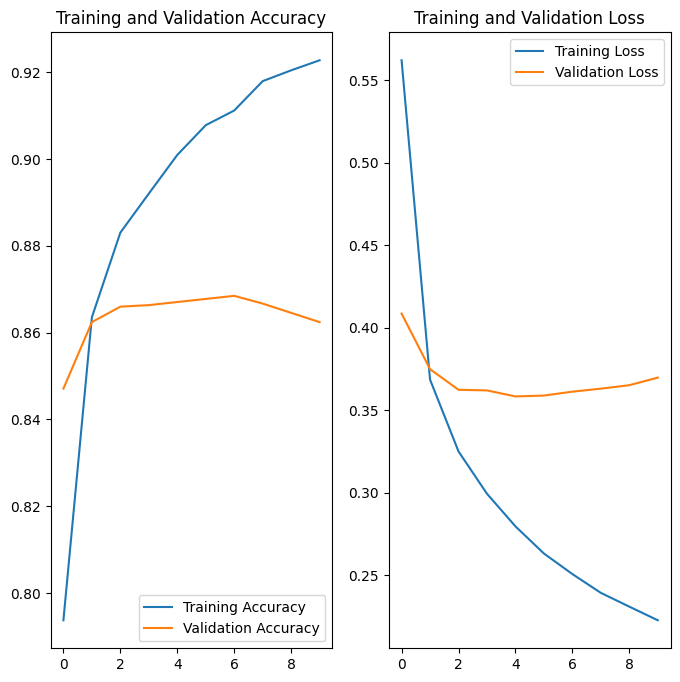

In [ ]:
# Grafica la precisión y pérdida de entrenamiento y validación
acc = history_tl.history['accuracy']
val_acc = history_tl.history['val_accuracy']

loss = history_tl.history['loss']
val_loss = history_tl.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

1/1 [==============================] - 0s 27ms/step


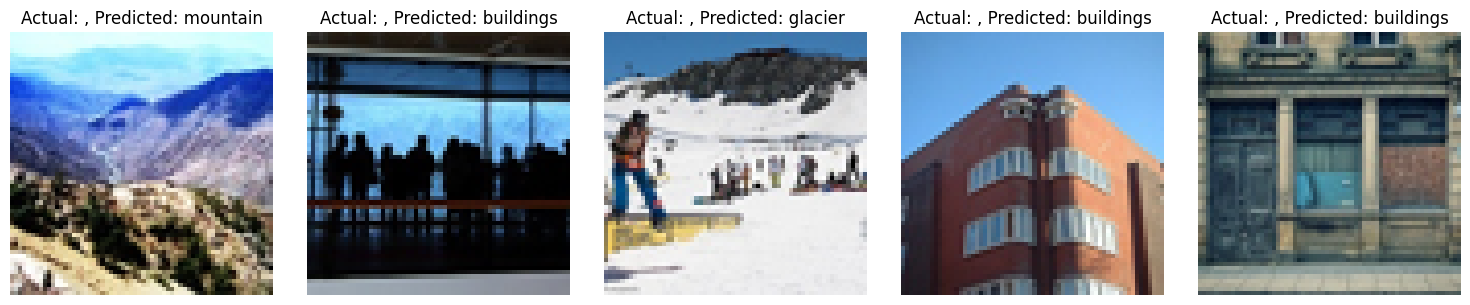

In [ ]:
# Function to preprocess the image
def preprocess_image(image_path, target_size=(64, 64)):
    img = Image.open(image_path)
    img = img.resize(target_size)
    return img

# Test images directory
TEST_IMAGES_DIRECTORY = Path("TP1-3/seg_pred/seg_pred")

# Get list of test image paths
test_image_paths = list(TEST_IMAGES_DIRECTORY.glob("*.jpg"))

# Display 5 images with their actual and predicted classes
fig, axes = plt.subplots(1, 5, figsize=(15, 3))

for i, ax in enumerate(axes):
    # Preprocess the image
    image_path = test_image_paths[i]
    image = preprocess_image(image_path)
    ax.imshow(image)
    ax.axis('off')

    image = np.expand_dims(image, axis=0)  # Add batch dimension

    # Perform prediction
    prediction = model_tl.predict(image)
    predicted_class_index = np.argmax(prediction)
    predicted_class = class_names[predicted_class_index]

    actual_class = ""
    if image_path.name.startswith("buildings"):
        actual_class = "buildings"
    elif image_path.name.startswith("forest"):
        actual_class = "forest"
    elif image_path.name.startswith("glacier"):
        actual_class = "glacier"
    elif image_path.name.startswith("mountain"):
        actual_class = "mountain"
    elif image_path.name.startswith("sea"):
        actual_class = "sea"
    elif image_path.name.startswith("street"):
        actual_class = "street"

#['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

    # Display result
    ax.set_title(f"Actual: {actual_class}, Predicted: {predicted_class}")

plt.tight_layout()
plt.show()